# An applied example of matplotlob transforms

PCA analysis (with a histogram plotted on a scatter plot)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

# Reproducibility seed
np.random.seed(123)

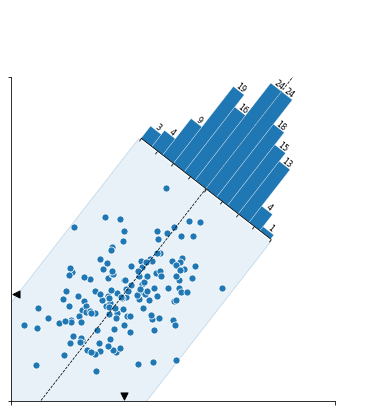

In [2]:
# Generate some data
Z0 = np.random.normal(0, (1.25, 0.75), (150, 2))  # Z0: 2D random points array
Z1 = Affine2D().rotate_deg(35).transform(Z0)      # Z1: rotated Z0
Zm = Z1.mean(axis=0)                              # mean of Z1. Zm = np.array([ 0.13746892, -0.02793329])


# Principal components analysis
# Note that for some seeds, the PC1 and PC2 needs to be inverted
# It could be fixed by looking at the orientation but I'm lazy
W, V = np.linalg.eig(np.cov(Z1.T))                 # W: eigenvalues, V: eigenvectors
PC1, PC2 = V[np.argsort(abs(W))]                   # PC1, PC2: 1st and 2nd Principal components
if PC2[1] < 0:                                     # to make PC2 "upwards"
    PC2 = -PC2
rotation = 180 * np.arctan2(*PC1) / np.pi
T = np.array([PC1[0], PC1[1]])                     # tangent vector of PC1 (a deep copy of PC1)
O = np.array([PC2[0], PC2[1]])                     # orthogonal vector of PC1 (a deep copy of PC2)


# Draw
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9], aspect=1)

# Main scatter plot
ax1.scatter(Z1[:, 0], Z1[:, 1], s=50, fc="C0", ec="white", lw=0.75)
ax1.set_xlim([-3, 6])
ax1.set_xticks([-3, 6])
ax1.set_xticklabels([])
ax1.set_ylim([-3, 6])
ax1.set_yticks([-3, 6])
ax1.set_yticklabels([])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


# Draw main PCA axis
P0 = np.vstack([Zm - T * 10, Zm + T * 10])         # P0 : endpoints of a long line along PC1
ax1.plot(P0[:, 0], P0[:, 1], color="black", linestyle="--", linewidth=0.75, zorder=10)

# Compute the width of the distribution along orthogonal direction to the PCA
# main axis. This is made by rotating points and taking max on the Y axis.
transform = Affine2D().rotate_deg(-rotation)
P1 = transform.transform(Z1 - Z1.mean(axis=0))     # P1 : rotated Z1, along x-axis
d = np.abs(P1[:, 1]).max()                         # d  : max. distance between P0 and Z1

# Draw a rectangle surrounding the distribution & oriented along PCA main axis
P2 = np.vstack(                                    # P2 : rectangle surrounding Z1
    [
        Zm - 10 * T - d * O,
        Zm + (6 - d) * T - d * O,
        Zm + (6 - d) * T + d * O,
        Zm - 10 * T + d * O,
    ]
)
ax1.add_patch(
    Polygon(
        P2,
        closed=True,
        fill=True,
        edgecolor="None",
        facecolor="C0",
        alpha=0.1,
        zorder=-50,
    )
)

# P3, P4 : edges of P2 parallel to PC1
P3 = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) - d * O  
plt.plot(P3[:, 0], P3[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)
P4 = np.vstack([Zm - 10 * T, Zm + (6 - d) * T]) + d * O
plt.plot(P4[:, 0], P4[:, 1], color="C0", linestyle="-", linewidth=0.75, alpha=0.25)

# Some markers on the axis to show the mean (we could compute exactly the delta
# for placing the marker but it is not the point of this example)
ax1.scatter(Zm[0], -2.85, s=50, color="black", marker="v", clip_on=False)
ax1.scatter(-2.85, Zm[1], s=50, color="black", marker="<", clip_on=False)


# Now the complicated stuff to orientate and translate the secondary axis

# 1. Compute the center of the histogram
C = Zm + 6 * T                                      # little bit far from the rectangle, along the PC1

# 2. Compute the coordinate and the size in normalized figure coordinates
x, y = fig.transFigure.inverted().transform(ax1.transData.transform(C))
xo, yo = fig.transFigure.inverted().transform(ax1.transData.transform(C + 2 * d * O))
h0 = w0 = np.sqrt((xo - x) ** 2 + (yo - y) ** 2)    # preparation of the histogram Axes

# 3. Create the secondary axis
#    Warning: it must be squared, ie. xmax-xmin = ymax-ymin
#    It is possible to have non squared axis, but it would complicate things.
xmin, xmax = -16, 16                               # "enough" large symmetric x limits for histogram
ymin, ymax = 0, xmax - xmin                        # y limits, same range but positive
transform = Affine2D().rotate_deg(-rotation)
helper = floating_axes.GridHelperCurveLinear(transform, (xmin, xmax, ymin, ymax))
ax2 = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper, zorder=0)

# 4. We know the size of the axis we want but it is rotated. When we specify
#    the size and position, it related to the non-rotate axis and we thus need
#    to compute the bounding box. To do that, we rotate the four coordinates
#    from which we deduce the bounding box coordinates.
transform = Affine2D().rotate_deg(-rotation)
R = transform.transform(                            # outline of the histogram Axes
    [
        (x - w0 / 2, y - h0 / 2),
        (x + w0 / 2, y - h0 / 2),
        (x - w0 / 2, y + h0 / 2),
        (x + w0 / 2, y + h0 / 2),
    ]
)
w1 = R[:, 0].max() - R[:, 0].min()                  # width of the histogram Axes
h1 = R[:, 1].max() - R[:, 1].min()                  # height of the histogram Axes
ax2.set_position((x - w1 / 2, y - h1 / 2, w1, h1))
fig.add_subplot(ax2)                                # Adding histogram Axes

# 5. Some decoration the secondary axis
ax2.axis["left"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticklabels.set_visible(False)
ax2.axis["bottom"].major_ticks.set_tick_out(True)
ax2.axis["left"].set_visible(False)
ax2.axis["right"].set_visible(False)
ax2.axis["top"].set_visible(False)
ax2.set_xticks([0, 1])
ax2.patch.set_visible(False)

# 6. Display the histogram, taking care of the extents of the X axis
counts, bins = np.histogram(-Z1 @ PC1, bins=12)     # histogram of -Z1 orthogonal to PC1 direction with 12 bins
X0 = (bins - bins[0]) / (bins[-1] - bins[0])        # X0 : normalized bins range [0, 1]
X1 = xmin + (xmax - xmin) * X0                      # X1 : stretched bins range [xmin, xmax] = [-16, 16]
Y = np.array(counts)

# This auxiliary axis is necessary to draw stuff (no real idea why)
ax2_aux = ax2.get_aux_axes(transform)

# Plotting histogram 
ax2_aux.hist(X1[:-1], X1, weights=Y, facecolor="C0", edgecolor="white", linewidth=0.25)

# 7. Adding some labels
dx, dy = (X1[1] - X1[0]) / 2, 0.75
for x, y in zip(X1, Y):
    ax2_aux.text(
        x + dx,
        y + dy,
        "%d" % y,
        ha="center",
        va="center",
        size=8,
        rotation=-rotation,
    )